# Clustering

In [1]:
import ais_processing
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiLineString, Polygon

In [2]:
df = gpd.read_file('AIS_2015_01_SF_Bay_transits.csv', GEOM_POSSIBLE_NAMES='geometry', KEEP_GEOM_COLUMNS='NO')

In [3]:
df.head()

,start_DTG,end_DTG,SOG,LOA_unbinned,day,month,length,max_SOG,LOA,geometry
0,2015-01-19 18:21:43,2015-01-20 00:03:48,47.7,28.65,Mon,Jan,7.900541642041586,40-50kt,0-100m,"LINESTRING (-122.38206 37.74708, -122.38202 37..."
1,2015-01-11 18:39:55,2015-01-12 04:13:36,11.3,27.42,Sun,Jan,1.5502465242070502,10-20kt,0-100m,"LINESTRING (-121.90111 38.04800, -121.90470 38..."
2,2015-01-16 09:12:44,2015-01-16 20:13:05,13.0,27.42,Fri,Jan,1.5471122663391763,10-20kt,0-100m,"LINESTRING (-121.90003 38.04878, -121.90000 38..."
3,2015-01-09 05:25:13,2015-01-09 15:02:24,9.9,27.42,Fri,Jan,1.5416339346080299,0-10kt,0-100m,"LINESTRING (-121.90071 38.04712, -121.90374 38..."
4,2015-01-10 05:47:36,2015-01-10 15:15:06,10.9,27.42,Sat,Jan,1.5387565264193501,10-20kt,0-100m,"LINESTRING (-121.90134 38.04802, -121.90414 38..."


In [4]:
df = df.drop(index=[0, 44], axis=1).reset_index()

In [5]:
transits = ais_processing.cluster_transits(df, hausdorff_threshold=0.35)

In [7]:
def combine_transits(df, transit):
    lines = list(df.geometry[transit])
    print(len(lines))
    return MultiLineString(lines)

5


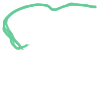

In [10]:
combine_transits(df, transits[0])

#### Write to a new gpd.GeoDataFrame broken down by characteristics

In [26]:
days = list(df.day.unique())
speeds = list(df.max_SOG.unique())
lengths = list(df.LOA.unique())
permutations = np.array(np.meshgrid(days, speeds, lengths)).T.reshape(-1,3)

In [28]:
Day = permutations[:,0]
Speed = permutations[:,1]
Length = permutations[:,2]
geometry = []

pd.DataFrame.from_dict({'Day': Day, 'Speed': Speed, 'Length': Length})

,Day,Speed,Length
0,Sun,10-20kt,0-100m
1,Sun,0-10kt,0-100m
2,Sun,20-30kt,0-100m
3,Sun,30-40kt,0-100m
4,Sun,40-50kt,0-100m
...,...,...,...
163,Thu,0-10kt,300-400m
164,Thu,20-30kt,300-400m
165,Thu,30-40kt,300-400m
166,Thu,40-50kt,300-400m


In [27]:
permutations[:,0]

array(['Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Fri', 'Fri', 'Fri',
       'Fri', 'Fri', 'Fri', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
       'Tue', 'Tue', 'Tue', 'Tue', 'Tue', 'Tue', 'Wed', 'Wed', 'Wed',
       'Wed', 'Wed', 'Wed', 'Mon', 'Mon', 'Mon', 'Mon', 'Mon', 'Mon',
       'Thu', 'Thu', 'Thu', 'Thu', 'Thu', 'Thu', 'Sun', 'Sun', 'Sun',
       'Sun', 'Sun', 'Sun', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri',
       'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Tue', 'Tue', 'Tue',
       'Tue', 'Tue', 'Tue', 'Wed', 'Wed', 'Wed', 'Wed', 'Wed', 'Wed',
       'Mon', 'Mon', 'Mon', 'Mon', 'Mon', 'Mon', 'Thu', 'Thu', 'Thu',
       'Thu', 'Thu', 'Thu', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun',
       'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Sat', 'Sat', 'Sat',
       'Sat', 'Sat', 'Sat', 'Tue', 'Tue', 'Tue', 'Tue', 'Tue', 'Tue',
       'Wed', 'Wed', 'Wed', 'Wed', 'Wed', 'Wed', 'Mon', 'Mon', 'Mon',
       'Mon', 'Mon', 'Mon', 'Thu', 'Thu', 'Thu', 'Thu', 'Thu', 'Thu',
       'Sun', 'Sun',

#### Build a test *non-production* gpd.GeoDataFrame that captures the clustered routes to test performance on the site

In [ ]:
max_SOG  = [df.max_SOG[transit].reset_index(drop=True)[0] for transit in transits]
LOA      = [df.LOA[transit].reset_index(drop=True)[0] for transit in transits]
geometry = [df.geometry[transit].reset_index(drop=True)[0] for transit in transits]

In [ ]:
pd.DataFrame.from_dict({'max_SOG': max_SOG, 'LOA': LOA, 'geometry': geometry})

In [ ]:
vessels = gpd.GeoDataFrame.from_dict({'Speed': max_SOG, 'Length': LOA, 'Geometry': geometry})

In [ ]:
vessels.to_csv('bay_traffic.csv')